Open this notebook in nbviewer to use the links. http://jiffyclub.github.io/open-in-nbviewer/

# Abstract
Electric vehicle (EV) manufacturer, Tesla, has been seen as a disruptive force in the auto-industry<sup>1</sup>. 
Indeed such growth is likened to the tech industry or even comparable to an entirely new industry<sup>2</sup>.<br/>  
By comparing quarterly balance sheets from US-based auto and tech companies over the past thirteen years, we explore if there is evidence from an asset-and-liabilities perspective to support such claims. <br/> 

This 2-part study will first attempt to validate the assumption that tech and auto industries are different with respect to their balance sheet and if the assumptions hold the second part will explore non-directional supporting evidence for the classification of Tesla into either Tech or Auto also only with regards to the balance sheet.<br/>

<br/>

<a id='top'><a/>
# Table of Contents
#### 1) Transforming time series data into de-trended, scaled and normalised format (i.i.d.) for tabular classification. 
    
   [Experiment 1.1 - grouping all companies as a whole for one transformation.](#expt1.1)
    
   [Pipeline and Hyperparameter Tuning](#pipe&Hyper)
    
   [Experiment 2.2 - individually transforming within companies across the same time-frame](#expt1.2)

#### 2) Use Statistics 
   [Experiment 2.1 - MANOVA](#expt2.1)
    
#### 3) Use Cluster Analysis 
   [Experiment 3.1 - k-means](#expt3.1)
    
#### 4) Use Sktime
   [Experiment 4.1 - ML Time Series Analysis](#expt4.1)

   [Appendix](#appendix)

## Data 
Data was manually **web scraped** from the SEC website.<br />
- See my [web_scraping_sec](https://github.com/mcsw311093/web_scraping_sec) repo for web-scraping with BeautifulSoup4 (BS4).


The whole process of **data-cleaning** can be found in [Data-Cleaning.ipynb](https://github.com/mcsw311093/Data-Cleaning-and-Analysis/blob/master/Data-Cleaning.ipynb) of the current repo.


# Aim and Motivation (Introduction)
##### Background
Finance Background 
Valuating a company is a difficult task.  Especially during these times of new companies disrupting different  industry. 

	- Classification role in Valuation
	Classification effects analyst and general public's perception of company value, internally (Assets) and externally (Sentiments, brand-loyalty)

	- Balance Sheet: an internal view of monetary value 
	Therefore, this study will focus on the effects of internal value on sector  classification, where internal value is represented by constituents of the balance sheet. 

Data Science background

    - Traditional means of analysis using machine learning have focused on  a particular distribution of data viz. Independent and identically distributed random variables.
    
    - Recent interest incorporating the time component of data has been seen (reference) with the development of  sktime API in sklearn, tsCV and tseries package in R. 
    
    - This study will compare the results of statistics methods and machine learning models. 

Therefore, this study will first address concerns that the difference in industry sectors is sufficiently represented in the quarterly and annual balance sheets.

If the above assumption holds, we will continue exploring the relationship between our target company (Tesla) and each industry. 

Finally, we will end our analysis with post-hoc analysis of the relationship of our chosen IVs and DVs. 

<br/>


##### Research Question
*Limitation: All comparisons and classifications are  **exclusively** based on shared data found in balance sheets of each company.<br/>*

ML and Statistics approach to solve 2 problems:
1) Testing our assumption distinct industries (population) can be inferred from the difference in variance within the balance sheet (sample).
Test Assumption: Distinct Industries on gernalized 'Balance Sheet' construct 
(Auto-industry != Tech-industry)

2) Explore
Can Tesla be classified into either one? Or neither? Or what percentage of Tesla's Assets and Liabilites resembles either industries.

To find support that the differences in industries are reflected in the balance sheet,

we will use multiple independent t-tests for each feature to see if there is any statistically significant difference in the pattern of each DV.

#### Approach & Experimental Set-up
###### **Part 1**
Exploratory data analysis and significance testing will be conducted to explore the **difference between the target industries.** <br/>
 - Ha: The sample means are different. <br/>
H0: The sample means are the same. (Reject?) <br/>
Method: (1) ML - Clustering; (2) Statistics - Factorial Analysis / Profile Analysis (Focus between groups)<br/>

###### **Part 2**
The percentage of **Tesla's balance sheet resembles** either one of our target industries' balance sheet. <br/>
- Ha1: Explore how much of Tesla is similar to Tech in comparison to Auto.<br/>
H01: Not applicable<br/>
Method:  <br/>

- Ha2: Explore how much of Tesla is similar to Auto in comparison to Tech.<br/>
H02: Not applicable<br/>
Method: 


###### **Post-hoc analysis**: **Interaction and main effects** between industries over time while controlling for Total Assets covariate.
- Ha: <br/>
H0: <br/>
Method: MANCOVA (Focus on DV construct) OR generalized linear model https://www.ibm.com/support/knowledgecenter/de/SSLVMB_24.0.0/spss/advanced/idh_idd_genlin_typeofmodel.html#idh_idd_genlin_typeofmodel
<br/>

###### **Post-hoc hypothesis**: 
<br/>
<br/>
<sup>1</sup>https://www.businessinsider.com/tesla-stock-value-compared-ford-gm-fca-car-production-charts-2020-7<br />
<sup>2</sup>https://www.investopedia.com/news/tesla-tech-company-or-car-company/

## Import Libraries

In [2]:
# import dataframe and libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Classification metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

# GridSearchCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns 
sns.set_style('darkgrid')
import altair as alt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', None)

from IPython.display import display
from IPython.core import display as ICD

In [3]:
# Power Transform
from sklearn.preprocessing import power_transform

from scipy.stats import boxcox
from scipy.stats import yeojohnson

# Difference computation function
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# StandardScaler
from sklearn.preprocessing import StandardScaler

# Normalization
from sklearn.preprocessing import MinMaxScaler

In [4]:
main_df = pd.read_csv('abt.csv')
main_df.set_index(['Year', 'Quarter'], drop=True, inplace=True)
main_df.sort_index(ascending=True, sort_remaining= True, inplace=True)

In [1]:
# main_df.groupby(main_df['company_name'], sort=True).sum()

# Methodology Overview

Previously we have handled missing data and feature engineering in another file therefore we will not re-do that here; we will start by exploring the data by looking at the correlations between the predictor variables to reduce multicollinearity. 

Then we will will perform data transformations to satisfy specific assumptions required by statiscal methods and models. For example, normality will be required for MANCOVA/Profile Analysis, stationatrity will be required for time series analysis. 

Finally we will run our experiments, analyse our data and report our findings.


# Exploratory Data Analysis

### Feature Selection 

#### Correlations
Do not look into normality at this stage. 

In [2]:
# Target variable is binanry in nature. 


In [3]:
# Assets should increase by time in each company


# distrubution of total_assets_liabities should show a normal d istribution in each industry (x-axis=frequency, y-axis=Total_assets_liabilities)



In [ ]:
# Heatmap to show correlation among the continuous variable. 
# Aim: see who is related to who, to increase predicatability and control over-inflated statistical significance. 

In [ ]:
# Zoomed heatmap on highest correlations
# Aim: find multicollinearity copies

In [ ]:
# Scatterplot on non-violating multicollinearity features.
# Aim: Find outliers in the predictors and assure linearity between predictors

#### sklearn.feature_selection.RFECV

#### Assumptions of Hypothesis-testing will be investigated step-wise, ie after each test-result.

Must click to check assumption testing for regression, how autoregression and Homoscedasticity and multicollinearity are related
https://www.analyticsvidhya.com/blog/2016/07/deeper-regression-analysis-assumptions-plots-solutions/#:~:text=An%20additive%20relationship%20suggests%20that,phenomenon%20is%20known%20as%20Autocorrelation.&text=Absence%20of%20this%20phenomenon%20is%20known%20as%20multicollinearity.

In [ ]:
# Normality testing


    # Histogram - Kurtosis and skewness.


    # Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution


# Absence of correlated errors 


# Homoscedasticity (equal levels of variance across the range of predictor variable) - Scatterplot
    # Departures from an equal dispersion are shown by such shapes as cones (small dispersion at one side of the graph, 
    # large dispersion at the opposite side) or diamonds (a large number of points at the center of the distribution).



## Data Preprocessing

In [6]:
#  Delete columns that will not be needed in Experiment 1.1.
main_df_1_1 = main_df.copy()
main_df_1_1.drop('Filing/Acc.No.', axis=1, inplace=True)
main_df_1_1.drop('company_name', axis=1, inplace=True)

In [7]:
#  Delete columns that will not be needed in Experiment 1.2.
main_df_1_2 = main_df.copy()
main_df_1_2.drop('Filing/Acc.No.', axis=1, inplace=True)

In [9]:
print(main_df.shape)
print(main_df_1_1.dtypes)
print(main_df_1_2.shape)

(292, 29)
Accounts Receivable               float64
Inventory                         float64
Total current assets              float64
Total current liabilities         float64
Total liabilities                 float64
Common Stock                      float64
Total liabilities and equity        int64
New Deferred Revenue              float64
New Property and Equipment        float64
Total Non-Current Assets          float64
Total_Assets                      float64
Non-Current Liabilities           float64
Total Shareholder's Equity        float64
Accounts Payables                 float64
Retained Earning                  float64
OCI                               float64
Accounts_Receivable_missing         int64
Common_Stock_missing                int64
Short_term_investments            float64
Short_term_investments_missing      int64
Inventory_missing                   int64
current_ratio                     float64
quick_ratio                       float64
debt_ratio              

A comparison of results between Scikit-Learn built-in preprocessing methods and Brown's transformation on Tesla_dataframe is provided in the appendix. Scikit-Learns methodology proved to 

#### Normalization
Normality need not to be assumed, let's see how the model performs first. We will try this if the unknown pattern cannot be mapped under the current parameter settings.

Decided to use Brown's method.

Inversion would not make sense in our case since we are not predicting variables as assumed in the Brown article, and we are not comparing a model performance (predictive or classifier or otherwise). 

***Here transforming acheives only one goal to standardise our different companies, so that reported financials can be compared directly accross companies.***

Brown Article on Time-Series Data Transformation for Machine Learning - https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/#:~:text=Stationary%20Time%20Series,-The%20observations%20in&text=Time%20series%20are%20stationary%20if,the%20variance%20of%20the%20observations.

In [23]:
def brown_transform(col_name, s, window):
    # Create a list to hold parameter information before transformation.
    para_list = []
    
    # Each Series -> variable s
    s = df[col_name]

    # Power Transform
    try:
        result, lmbda = boxcox(s)
#         print('box_cox')
#         print(lmbda)
        para_list.append(['B-C', lmbda])
        
    except ValueError:
        result, lmbda = yeojohnson(s.values.reshape(-1,1))
#         print('Yeo-Johnson')
        
        if type(lmbda) == np.float64:
            para_list.append(['Y-J', lmbda])
            
        else:
    #         print(f'lambda {lmbda} {type(lmbda)}')
            lmbda = lmbda[0]
            para_list.append(['Y-J', lmbda])
        
    # Difference Transform
    diff_res = difference(result, window)

    # StandardScaler
    # Turn 1-D array of lists into a 2-D array 
    diff_res = np.array(diff_res).reshape(len(diff_res), 1)
    
    para_list.append(np.mean(diff_res))
    para_list.append(np.std(diff_res))
    
    standard_res = StandardScaler().fit_transform(diff_res)

    # Normalization
#     para_list.append(min(standard_res)[0])
#     para_list.append(max(standard_res)[0])
    
    norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
    norm_res = [ s[0] for s in norm_res]
    trans_para_.update({ col_name : para_list} )
    
    return norm_res

The above preprocessing steps do not require a GridSearch to optimise parameter tuning. 

**Power Transform:** Boxcox() automates the lambda parameter by maximising  the log likelihood function for non-negative power transformations.

Since our data contains negative, zero-values, and postive values. BoxCox limitations in negative numerals is handled by Y-J; while zero values are handled by BoxCox which cannot be handled by Y-J.

**Difference Transform** Utilises the value difference between t=0 and t+=interval to smooth out trends and seasonality. Since our data is quarterly based, interval = 4.

**StandardScaler** Uses the mean and sd to normalise the data with zero mean and unit variance. 

**Normalization** Scales the data to fit with a predefined range (usually 0-1) for better comparison. 

Therefore, parameter tuning for preprocessing steps is unnecessary.

In order to prevent data leakage we will split the training and testing data first and apply training preprocessing parameters to the test set. 

### Isolate Train-model-data (non-Tesla Data) from data of interest (Tesla Data).

In [16]:
tesla_df_1_1 = main_df_1_1[main_df_1_1['industry'].isna()]
tesla_df_1_1.shape

(22, 27)

## Feature Selection
3 Methods: <br/>
**Categorical Feature Selection**<br/>
**Numerical Feature Selection — Regression Problem**<br/>
**Wrapper** 

Wrapper Method
sklearn.feature_selection.RFECV <br/>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

Example<br/>
https://towardsdatascience.com/how-to-find-the-best-predictors-for-ml-algorithms-4b28a71a8a80

#### Train_df

In [17]:
Train_df_1_1 = main_df_1_1[main_df_1_1['industry'].notna()]
Train_df_1_1.shape

(270, 27)

#### Train_df

In [18]:
# Create separate object for target variable
y = Train_df_1_1.industry

# Create separate object for input features
X = Train_df_1_1.drop('industry', axis=1)

In [19]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=Train_df_1_1.industry)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

216 54 216 54


In [20]:
X_test.sort_index(ascending=True, sort_remaining= True, inplace=True)
X_test.shape

C:\Users\Matthew\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(54, 26)

In [21]:
X_train.sort_index(ascending=True, sort_remaining= True, inplace=True)
X_train.shape

C:\Users\Matthew\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(216, 26)

<a id='expt1.1'></a>

## (Exploratory) Factor Analysis 

Factor Analysis
    https://www.researchgate.net/post/What_is_the_concept_of_Total_Variance_Explained_in_Factor_Analysis_and_how_can_it_be_used

Exploratory Factor Analysis (Principal Axis Factoring vs. Principal Components Analysis) in SPSS
    https://www.youtube.com/watch?v=5KN_CTgviYs&list=PLdlFfrVsmlvD59VY7hwIfxtCjDoELpknK

# Experiment 1.1 - grouping all companies as a whole for one transformation
<a href='#top'>Top of Page</a>

### 1) Transforming Tech Industry training_dfs

Accounts Receivable


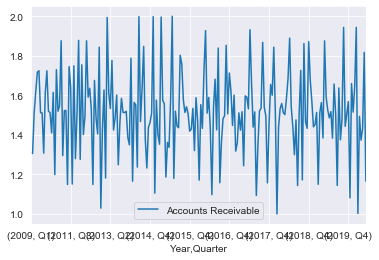

Inventory


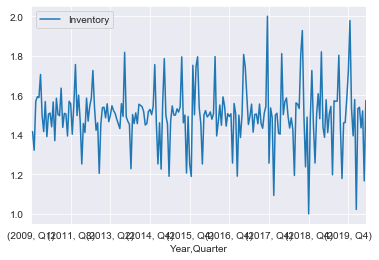

Total current assets


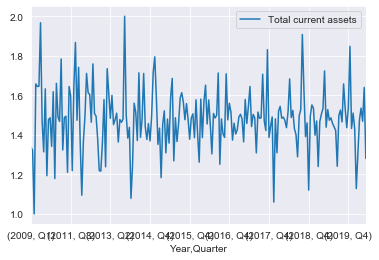

Total current liabilities


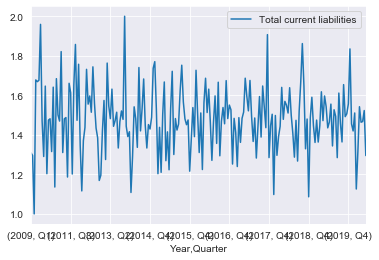

Total liabilities


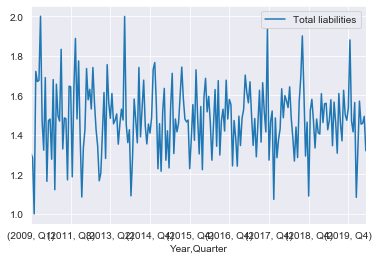

Common Stock


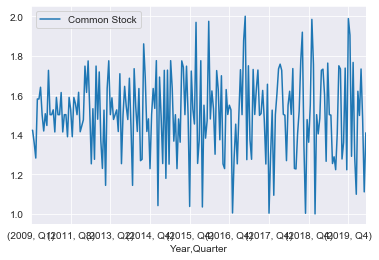

New Deferred Revenue


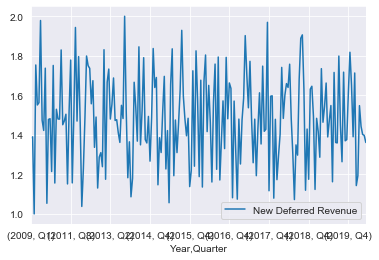

New Property and Equipment


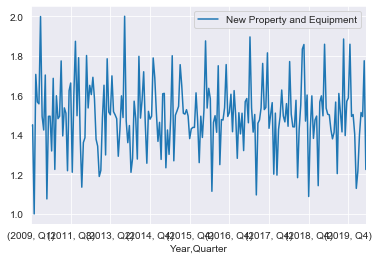

Total Non-Current Assets


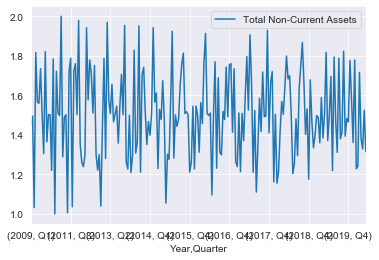

Total_Assets


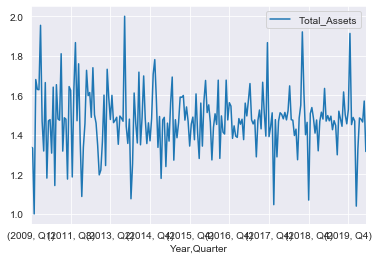

Non-Current Liabilities


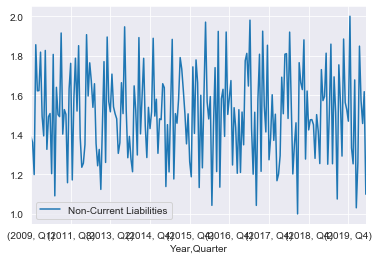

Total Shareholder's Equity


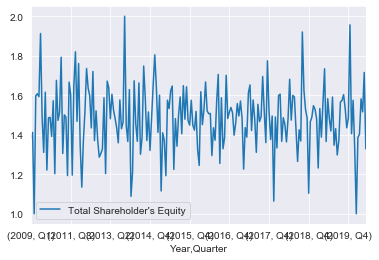

Accounts Payables


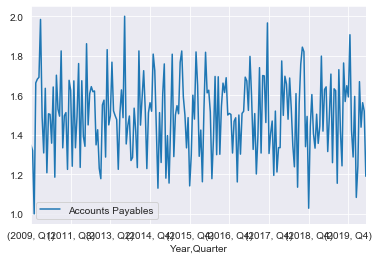

Retained Earning


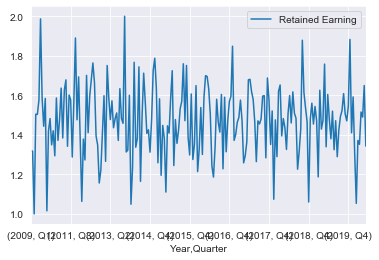

OCI


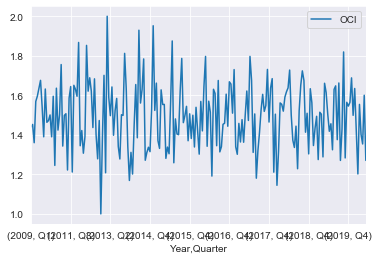

Short_term_investments


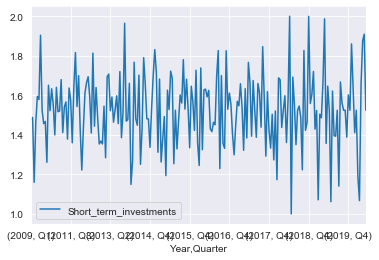

current_ratio


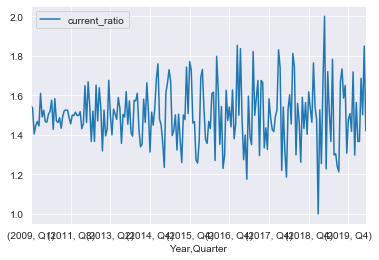

quick_ratio


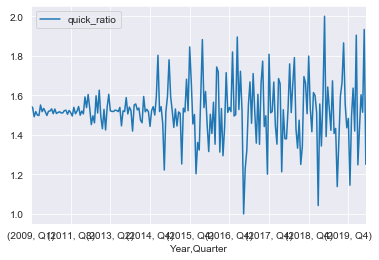

debt_ratio


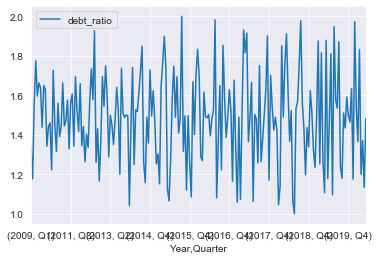

debt_to_equity_ratio


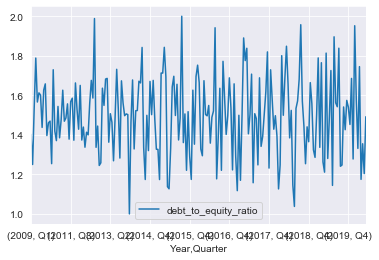

equity_multiplier


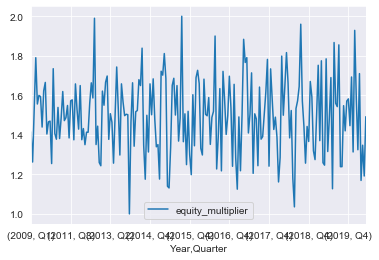

In [24]:
df = X_train
# Create dictionary to save the transformation parameters.
trans_para_ = {}

transformed_df_list = []

# Apply to all training columns. 
for col_name in df.columns:
        
    # Apply only to numeric columns. 
    if df[col_name].dtypes == 'float64':
            
        s = df[col_name]
        
        # Brown's Transformation Suggestions
        result = brown_transform(col_name, s, 4)
        
        transformed_df = pd.DataFrame({col_name:result}, index=df.index[4:] )
        
        transformed_df.plot(kind='line')
        transformed_df_list.append(transformed_df)
        
        print(col_name)
        plt.show()
        

In [25]:
new_X_train = pd.concat(transformed_df_list, axis=1)

## <!>Transform only skewed data 
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/comments
- the code skewness = skewness[abs(skewness) > 0.75] should be wrote as skewness = skewness[abs(skewness.Skew)>0.75]<br/>

**Check the skew of all numerical features**<br/>
- <code>skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)<code/>
    
    
src: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

### Implement the training transformations onto X_test with trans_para_.

In [28]:
# X_test_new = scaler.transform(X_test)
X_test_new_list = []
for col, parameters in trans_para_.items():
    
    power_T = parameters[0][0]
    
    lmbda = parameters[0][1]
    
    mean_ = parameters[1]
    
    std_ = parameters[2]
    
    s = X_test[col]
#     s.plot(title=col)
#     plt.show()
    
    # Power Transformation
    if power_T == 'B-C':
        result = boxcox(s, lmbda)
        
    elif power_T == 'Y-J':
        result = yeojohnson(s, lmbda)
    
    # Difference Transformation
    diff_res = difference(result, 4)
    
    # StandardScaler 
    diff_res = np.array(diff_res).reshape(len(diff_res), 1)
    standard_res = StandardScaler(with_mean = mean_, 
                                 with_std = std_ ).fit_transform(diff_res)
    
    # Normalization
    norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
    norm_res = [ s[0] for s in norm_res]
    
    df = pd.DataFrame(dict({col: norm_res}), index=s.index[4:])
    X_test_new_list.append(df)
    
#     X_test_new.plot(title=col)
#     plt.show()
    

In [29]:
new_X_Test = pd.concat(X_test_new_list, axis=1)
new_X_Test.head()

Accounts Receivable  Inventory  Total current assets  \
Year Quarter                                                         
2009 Q2                  1.523746   1.496204              1.513926   
2010 Q4                  1.266977   1.634404              1.899289   
2011 Q3                  1.549089   1.511636              1.554012   
2012 Q2                  1.508746   1.656910              1.607268   
     Q3                  1.266768   1.487687              1.421457   

              Total current liabilities  Total liabilities  Common Stock  \
Year Quarter                                                               
2009 Q2                        1.510675           1.495287      1.496665   
2010 Q4                        1.796102           1.814590      1.544673   
2011 Q3                        1.552951           1.550655      1.500542   
2012 Q2                        1.599878           1.624281      1.495277   
     Q3                        1.440493           1.467014      1.431104   

              New Deferred Revenue  New Property and Equipment  \
Year Quarter                                                     
2009 Q2                   1.493422                    1.494713   
2010 Q4                   1.826390                    2.000000   
2011 Q3                   1.473909                    1.560760   
2012 Q2                   1.525505                    1.458983   
     Q3                   1.459607                    1.382202   

              Total Non-Current Assets  Total_Assets  Non-Current Liabilities  \
Year Quarter                                                                    
2009 Q2                       1.589083      1.524589                 1.493380   
2010 Q4                       1.707728      1.907264                 1.913987   
2011 Q3                       1.512014      1.563134                 1.580089   
2012 Q2                       1.395704      1.602019                 1.563935   
     Q3                       1.338398      1.434601                 1.427541   

              Total Shareholder's Equity  Accounts Payables  Retained Earning  \
Year Quarter                                                                    
2009 Q2                         1.628471           1.506001          1.484405   
2010 Q4                         2.000000           1.867868          2.000000   
2011 Q3                         1.567562           1.553316          1.640237   
2012 Q2                         1.523780           1.481429          1.708873   
     Q3                         1.347003           1.337985          1.597958   

                   OCI  Short_term_investments  current_ratio  quick_ratio  \
Year Quarter                                                                 
2009 Q2       1.632924                1.594188       1.525211     1.479349   
2010 Q4       1.733061                1.961786       1.640760     1.492178   
2011 Q3       1.558116                1.662253       1.468963     1.469919   
2012 Q2       1.467395                1.620498       1.486035     1.433224   
     Q3       1.378804                1.536860       1.475057     1.446840   

              debt_ratio  debt_to_equity_ratio  equity_multiplier  
Year Quarter                                                       
2009 Q2         1.168713              1.069865           1.042197  
2010 Q4         1.450827              1.447527           1.457141  
2011 Q3         1.477233              1.477145           1.489894  
2012 Q2         1.801843              1.751837           1.767145  
     Q3         1.719369              1.701185           1.724642

Below is a visual illustration of what happens when we transform our data using brown_transform(). 

<img src='before_and_after_transformation.png'>

<a id='pipe&Hyper'></a>
### Pipeline and Hyperparameters
<a href='#top'>Top of Page</a>

[Expt 2.2 - Train Model](#expt2.2train)

In [30]:
# Pipeline dictionary Classifiers
pipelines = {
    'l1' : make_pipeline(LogisticRegression(penalty='l1', random_state=123)),
    'l2' : make_pipeline(LogisticRegression(penalty='l2', random_state=123)),
    'rf' : make_pipeline(RandomForestClassifier(random_state=123)),
    'gb' : make_pipeline(GradientBoostingClassifier(random_state=123))
}

In [31]:
# Logistic Regression hyperparameters
l1_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

l2_hyperparameters = {
    'logisticregression__C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
}

# Random Forest hyperparameters
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}

# Boosted Tree hyperparameters
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2],
    'gradientboostingclassifier__max_depth': [1, 3, 5]
}

In [32]:
# Create hyperparameters dictionary
hyperparameters = {
    'l1' : l1_hyperparameters,
    'l2' : l2_hyperparameters,
    'rf' : rf_hyperparameters,
    'gb' : gb_hyperparameters
}

## Fit and Tune Model with Cross-Validation

In [33]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(new_X_train, y_train[4:])
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


l1 has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


l2 has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


rf has been fitted.
gb has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
for name, model in fitted_models.items():
    pred = model.predict_proba(new_X_Test)
    pred = [p[1] for p in pred]
    
    print( name, roc_auc_score(y_test[4:], pred) )

l1 0.376984126984127
l2 0.5595238095238095
rf 0.498015873015873
gb 0.503968253968254


Plot the highest AUROC score.

In [35]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models['l2'].predict_proba(new_X_Test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
print( np.round(pred[:10], 2) )

[0.65 0.68 0.66 0.67 0.66 0.64 0.68 0.67 0.68 0.67]


In [36]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(y_test[4:], pred)

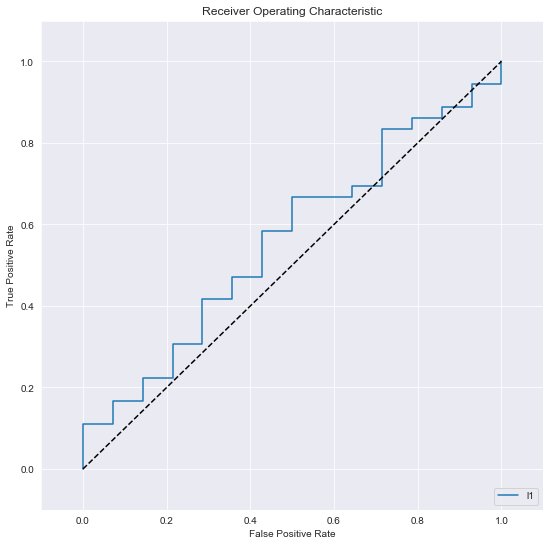

In [37]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The above shows the classification where tech is the positive class.

Now reversing the positive class from the Tech industry to Automobile. 


In [38]:
def swapping_targets(y):
    swapped_y_list = []

    for value in y.values:

        if value == 1:
            swapped_y_list.append(0)

        if value == 0:
            swapped_y_list.append(1)
            
    swapped_y = pd.Series(swapped_y_list, index=y.index)
    
    return swapped_y

In [39]:
new_y_train = swapping_targets(y_train)

In [40]:
new_y_test = swapping_targets(y_test)

In [41]:
# Create empty dictionary called fitted_models
fitted_models_2 = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(new_X_train, new_y_train[4:])
    
    # Store model in fitted_models[name] 
    fitted_models_2[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


l1 has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


l2 has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


rf has been fitted.
gb has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [42]:
for name, model in fitted_models_2.items():
    pred = model.predict_proba(new_X_Test)
    pred = [p[1] for p in pred]
    
    print( name, roc_auc_score(new_y_test[4:], pred) )

l1 0.5
l2 0.5595238095238095
rf 0.498015873015873
gb 0.503968253968254


Swapping 0 and 1 produces the same results except for l1. 

In [43]:
# Predict PROBABILITIES using L1-regularized logistic regression
pred = fitted_models_2['l2'].predict_proba(new_X_Test)

# Get just the prediction for the positive class (1)
pred = [p[1] for p in pred]

# Display first 10 predictions
print( np.round(pred[:10], 2) )

[0.35 0.32 0.34 0.33 0.34 0.36 0.32 0.33 0.32 0.33]


In [44]:
# Calculate ROC curve from y_test and pred
fpr, tpr, thresholds = roc_curve(new_y_test[4:], pred)

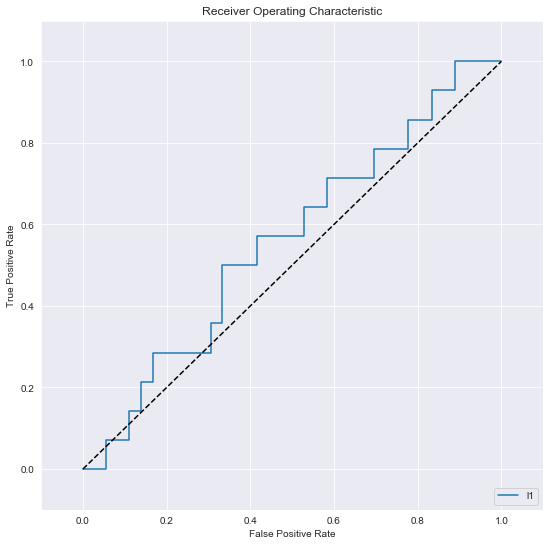

In [45]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist

## Expt 1.1 Conclusion
We will not try classifying Tesla into the models under these preprocessing conditions, because the predictability of the model is as good as chance.


<a id='expt1.2'></a>

# Experiment 1.2 - individually transforming within companies across the same time-frame
<a href='#top'>Top of Page</a>

In [46]:
tesla_df_1_2 = main_df_1_2[main_df_1_2['industry'].isna()]
Train_df_1_2 = main_df_1_2[main_df_1_2['industry'].notna()]

In [47]:
# Create separate object for target variable
y = Train_df_1_2.industry

# Create separate object for input features
X = Train_df_1_2.drop('industry', axis=1)

In [48]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234,
                                                    stratify=Train_df_1_2.industry)

# Print number of observations in X_train, X_test, y_train, and y_test
print( len(X_train), len(X_test), len(y_train), len(y_test) )

216 54 216 54


In [49]:
X_test.sort_index(ascending=True, sort_remaining= True, inplace=True)
X_train.sort_index(ascending=True, sort_remaining= True, inplace=True)

C:\Users\Matthew\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Matthew\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
company_list = [name for name in X_train.company_name.unique()]

In [51]:
df_lst = []
for name in company_list:
    company_df = X_train[X_train['company_name']==name]
    df_lst.append(company_df)

In [52]:
company_dfs = dict(zip(company_list, df_lst))

In [53]:
for name, df in company_dfs.items():
    print(name)
    partial_df = df.head(2)
    print(df.shape)
#     ICD.display(partial_df)

Amazon
(39, 27)
Netflix
(39, 27)
GM
(35, 27)
Microsoft
(28, 27)
Ford
(23, 27)
Apple
(20, 27)
Facebook
(16, 27)
Google
(16, 27)


new_brown_transform without difference transformation because too little data, seperating into company_df's drastically scarificed more data, expecially in X_test. 

In [54]:
def new_brown_transform(col_name, s):
    # Create a list to hold parameter information before transformation.
    para_list = []
    
    # Each Series -> variable s
    s = df[col_name]

    # Power Transform
    try:
        result, lmbda = boxcox(s)
#         print('box_cox')
#         print(lmbda)
        para_list.append(['B-C', lmbda])
        
    except ValueError:
        result, lmbda = yeojohnson(s.values.reshape(-1,1))
#         print('Yeo-Johnson')
        
        if type(lmbda) == np.float64:
            para_list.append(['Y-J', lmbda])
            
        else:
    #         print(f'lambda {lmbda} {type(lmbda)}')
            lmbda = lmbda[0]
            para_list.append(['Y-J', lmbda])
        
#     # Difference Transform
#     diff_res = difference(result, window)

    # StandardScaler
    # Turn 1-D array of lists into a 2-D array 
    #diff_res = array(diff_res).reshape(len(diff_res), 1)
    
    para_list.append(np.mean(result))
    para_list.append(np.std(result))
    
    result = np.array(result).reshape(len(result), 1)
    standard_res = StandardScaler().fit_transform(result)

    # Normalization
#     para_list.append(min(standard_res)[0])
#     para_list.append(max(standard_res)[0])
    
    norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
    norm_res = [ s[0] for s in norm_res]
    trans_para_.update({ col_name : para_list} )
    
    return norm_res

 **Perform columnar transformation on each company-dataframe.**

In [55]:
# { Company Name : {feat_name : [parameters]} }
company_trans_para = {}

trfm_com_df_lst = []

# For each company
for name, df in company_dfs.items():
    print(name)
    # Create dictionary to save the transformation parameters.
    trans_para_ = {}

    transformed_df_list = []

    # Apply to all training columns within that company.
    for col_name in df.columns:

        # Apply only to numeric columns. 
        if df[col_name].dtypes == 'float64':

            s = df[col_name]

            # Brown's Transformation Suggestions
            result = new_brown_transform(col_name, s)
            
            # Transformed Series 
            transformed_df = pd.DataFrame({col_name:result}, index=df.index )
            transformed_df_list.append(transformed_df)
#             transformed_df.plot(kind='line')
#             print(col_name)
#             plt.show()
            
    # Transformed Dataframe, gluing series tgt
    trans_df = pd.concat(transformed_df_list, axis=1)
    
    # Append transformed df to df_list
    trfm_com_df_lst.append(trans_df)
    
    # Saving transformation parameters. 
    company_trans_para[name] = trans_para_
    
#     if name == 'GM':
#         break

Amazon
Netflix
GM
Microsoft
Ford
Apple


C:\Users\Matthew\Anaconda3\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1960: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\Matthew\Anaconda3\lib\site-packages\numpy\core\_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1465: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1959: RuntimeWarning: invalid value encountered in subtract
  tmp1 = (x - w) * (fx - fv)
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1960: RuntimeWarning: invalid value encountered in subtract
  tmp2 = (x - v) * (fx - fw)
C:\Users\M

Facebook
Google


C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1465: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1959: RuntimeWarning: invalid value encountered in subtract
  tmp1 = (x - w) * (fx - fv)
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1960: RuntimeWarning: invalid value encountered in subtract
  tmp2 = (x - v) * (fx - fw)
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1963: RuntimeWarning: invalid value encountered in greater
  if (tmp2 > 0.0):
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:1969: RuntimeWarning: invalid value encountered in greater
  if ((p > tmp2 * (a - x)) and (p < tmp2 * (b - x)) and
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1465: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.lo

#### new_X_train

In [56]:
new_X_train = pd.concat(trfm_com_df_lst, axis=0)
print(new_X_train.shape)
new_X_train.head()

(216, 21)


Accounts Receivable  Inventory  Total current assets  \
Year Quarter                                                         
2008 Q2                  1.000000   1.000000              1.000000   
     Q4                  1.046352   1.018178              1.059731   
2009 Q1                  1.000425   1.030468              1.036059   
     Q3                  1.033905   1.089016              1.123494   
     Q4                  1.086813   1.053891              1.113165   

              Total current liabilities  Total liabilities  Common Stock  \
Year Quarter                                                               
2008 Q2                        1.000000           1.001848           1.0   
     Q4                        1.036248           1.066570           1.0   
2009 Q1                        1.014677           1.000000           1.0   
     Q3                        1.087624           1.071278           1.0   
     Q4                        1.099344           1.083033           1.0   

              New Deferred Revenue  New Property and Equipment  \
Year Quarter                                                     
2008 Q2                   1.199735                    1.025731   
     Q4                   1.173824                    1.000000   
2009 Q1                   1.098298                    1.071467   
     Q3                   1.075862                    1.101904   
     Q4                   1.131224                    1.065460   

              Total Non-Current Assets  Total_Assets  Non-Current Liabilities  \
Year Quarter                                                                    
2008 Q2                       1.272701      1.000000                 1.060080   
     Q4                       1.000000      1.007041                 1.180042   
2009 Q1                       1.277832      1.027393                 1.000000   
     Q3                       1.308189      1.096932                 1.053939   
     Q4                       1.260952      1.075823                 1.064682   

              Total Shareholder's Equity  Accounts Payables  Retained Earning  \
Year Quarter                                                                    
2008 Q2                         1.156798           1.000000          1.388793   
     Q4                         1.000000           1.090823          1.437582   
2009 Q1                         1.224426           1.048964          1.253527   
     Q3                         1.276143           1.139437          1.046902   
     Q4                         1.202285           1.158185          1.310867   

                   OCI  Short_term_investments  current_ratio  quick_ratio  \
Year Quarter                                                                 
2008 Q2       1.009421                1.094787       1.826232     1.771855   
     Q4       1.000000                1.000000       1.892237     1.881477   
2009 Q1       1.314248                1.149511       1.900273     1.838581   
     Q3       1.138366                1.245560       1.903074     1.859403   
     Q4       1.291136                1.131042       1.806162     1.807651   

              debt_ratio  debt_to_equity_ratio  equity_multiplier  
Year Quarter                                                       
2008 Q2         1.258568              1.251105           1.243641  
     Q4         2.000000              2.000000           2.000000  
2009 Q1         1.096685              1.100137           1.095950  
     Q3         1.136933              1.138868           1.133541  
     Q4         1.357605              1.340533           1.332355

### Implement the training transformations onto X_test with trans_para_.


In [57]:
test_df_lst = []
for name in company_list:
    company_df = X_test[X_test['company_name']==name]
    test_df_lst.append(company_df)

In [58]:
test_company_dfs = dict(zip(company_list, test_df_lst))

In [59]:
# Too little data!!!! 
test_company_dfs['Microsoft']['Accounts Receivable']

Year  Quarter
2014  Q1         1.349700e+10
2015  Q3         1.144400e+10
2017  Q1         1.288200e+10
2018  Q1         1.720800e+10
Name: Accounts Receivable, dtype: float64

In [60]:
# X_test_new = scaler.transform(X_test)
X_test_new_list = []

for company, trans_para_ in company_trans_para.items():
    
    transformed_df_list = []
    
    for col, parameters in trans_para_.items():

        power_T = parameters[0][0]

        lmbda = parameters[0][1]

        mean_ = parameters[1]

        std_ = parameters[2]

        s = test_company_dfs[company][col]

        # Power Transformation
        if power_T == 'B-C':
            try:
                result = boxcox(s, lmbda)
                
            except: 
#                 print('Original s \n', s)
                ss = s.copy()
                ss = np.array([num+1 if num == 0 else num for num in s ])
#                 print('New s \n', s)
                result = boxcox(ss, lmbda) 
                
#                 print(company, 'has a negative value.')
#                 s.plot(title=col)
#                 print(s)
#                 result = boxcox(abs(s), lmbda)
                
        elif power_T == 'Y-J':
            result = yeojohnson(s, lmbda)
           
        # Difference Transformation
#         diff_res = difference(result, 4)
        
        # StandardScaler 
#         diff_res = array(diff_res).reshape(len(diff_res), 1)
        result = np.array(result).reshape(len(result), 1)
    
        try:
            standard_res = StandardScaler(with_mean = mean_, 
                                     with_std = std_ ).fit_transform(result)
        except:
            print(company, col)
            print('wrong?')
            print(result)
            print('after difference() and reshape', diff_res)
        # Normalization
        norm_res = MinMaxScaler(feature_range=(1,2)).fit_transform(standard_res)
        norm_res = [ s[0] for s in norm_res]
        
        # Transformed Series
        transformed_df = pd.DataFrame(dict({col: norm_res}), index=s.index)
        transformed_df_list.append(transformed_df)
        
    # Transformed Dataframe, gluing series tgt, per company
    trans_df = pd.concat(transformed_df_list, axis=1)
    
    # Append transformed df to df_list
    X_test_new_list.append(trans_df)
    
    print(f'{company} is transformed and added.')

Amazon is transformed and added.
Netflix is transformed and added.
GM is transformed and added.
Microsoft is transformed and added.
Ford is transformed and added.
Apple is transformed and added.
Facebook is transformed and added.
Google is transformed and added.


In [61]:
new_X_Test = pd.concat(X_test_new_list, axis=0)
print(new_X_Test.shape)
new_X_Test.head()

(54, 21)


Accounts Receivable  Inventory  Total current assets  \
Year Quarter                                                         
2007 Q4                  1.000000   1.000000              1.000000   
2008 Q1                  1.091351   1.046824              1.050432   
     Q3                  1.098041   1.094951              1.085208   
2009 Q2                  1.092618   1.096830              1.142007   
2011 Q3                  1.331258   1.397845              1.402166   

              Total current liabilities  Total liabilities  Common Stock  \
Year Quarter                                                               
2007 Q4                        1.000000           1.000000           1.0   
2008 Q1                        1.088711           1.030803           1.0   
     Q3                        1.056393           1.007153           1.0   
2009 Q2                        1.095042           1.031167           1.0   
2011 Q3                        1.350001           1.286902           2.0   

              New Deferred Revenue  New Property and Equipment  \
Year Quarter                                                     
2007 Q4                   1.000000                    1.000000   
2008 Q1                   1.142676                    1.038140   
     Q3                   1.167494                    1.069325   
2009 Q2                   1.026233                    1.115091   
2011 Q3                   1.063691                    1.361383   

              Total Non-Current Assets  Total_Assets  Non-Current Liabilities  \
Year Quarter                                                                    
2007 Q4                       1.000000      1.000000                 1.127505   
2008 Q1                       1.399274      1.079680                 1.021019   
     Q3                       1.423297      1.108999                 1.029242   
2009 Q2                       1.453183      1.150694                 1.000000   
2011 Q3                       1.537167      1.394488                 1.238229   

              Total Shareholder's Equity  Accounts Payables  Retained Earning  \
Year Quarter                                                                    
2007 Q4                         1.000000           1.000000          1.404015   
2008 Q1                         1.261943           1.007451          1.300261   
     Q3                         1.377144           1.060960          1.232611   
2009 Q2                         1.430942           1.094119          1.000000   
2011 Q3                         1.614969           1.400039          1.395643   

                   OCI  Short_term_investments  current_ratio  quick_ratio  \
Year Quarter                                                                 
2007 Q4       1.000000                1.129524       1.832628     1.818130   
2008 Q1       1.098131                1.000000       1.386436     1.468221   
     Q3       1.346135                1.008739       1.940203     1.827057   
2009 Q2       1.312132                1.206737       2.000000     2.000000   
2011 Q3       1.572810                1.531816       1.822973     1.667030   

              debt_ratio  debt_to_equity_ratio  equity_multiplier  
Year Quarter                                                       
2007 Q4         2.000000              2.000000           2.000000  
2008 Q1         1.364138              1.257786           1.252524  
     Q3         1.056946              1.041453           1.039704  
2009 Q2         1.000000              1.000000           1.000000  
2011 Q3         1.022608              1.016769           1.015999

We will be using the same pipeline and hyperparameters as experiment 1.1. 
<a id='expt2.2train'></a>

[Click](#pipe&Hyper)
here to view again.


## Fit and Tune Model with Cross-Validation

In [62]:
# Create empty dictionary called fitted_models
fitted_models = {}

# Loop through model pipelines, tuning each one and saving it to fitted_models
for name, pipeline in pipelines.items():
    # Create cross-validation object from pipeline and hyperparameters
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # Fit model on X_train, y_train
    model.fit(new_X_train, y_train)
    
    # Store model in fitted_models[name] 
    fitted_models[name] = model
    
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


l1 has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


l2 has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


rf has been fitted.
gb has been fitted.


C:\Users\Matthew\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [63]:
for name, model in fitted_models.items():
    pred = model.predict_proba(new_X_Test)
    pred = [p[1] for p in pred]
    
    print( name, roc_auc_score(y_test, pred) )

l1 0.45299145299145305
l2 0.5008547008547009
rf 0.5487179487179488
gb 0.5384615384615384


## Expt 1.2 Conclusion
Our best classifer did not perform better than chance. Whether we transform the features across multiple industies as a whole or transform within each company. 
However, unlike expt 1.1, expt 1.2 did not perform the difference transformation. This may introduce some confounding variables, but since we did not have enough data, it is a limitation of this study.

# Experiment 2.1 - 2x4 Mixed MANCOVA/ Profile Analysis
<a href='#top'>Top of Page</a>

Homogeneity of variance-covariance matrices</br>
https://www.introspective-mode.org/data-assumption-homogeneity-of-variance-covariance/#:~:text=In%20short%2C%20homogeneity%20of%20variance,in%20MANOVA)

Homogeneity of regression slopes</br>
https://www.introspective-mode.org/assumption-homogeneity-parallelism/

<!> Profile Analysis is a mixed MANOVA:  http://userwww.sfsu.edu/efc/classes/biol710/manova/profileSPSS-Worked-Ex.htm <br/>
Example using SPSS, note SPSS deafults to using type III (focus on Interaction) (Type I sequential; type II assumes no interaction)

Difference between MANOVA and Profile analysis ( PA needs to be on the same scale) <br/>

Three Hypothesis same as MANOVA and Profile Analysis <br/>
H1: MANOVA is called Between Subject (IV) Main Effect (in PA is called Levels hypothesis) The 2 groups are different <br/>
H2: MANOVA is called Within Subject (DV) Main Effect (in PA is called Flatness hypothesis) Difference within a group <br/>
H3: MANOVA is called Interaction (IV & DV) (in PA is called Parallelism (of Profiles) hypothesis)  <br/>


Analyse in SPSS because python statsmodels.api does not have MANCOVA (only MANOVA). We would like to control for the covariate ***Total Assets*** (Elmberger & Makdisi-Somi, 2016)<sup>1</sup> to level the playing field of individuals<sup>2</sup>.

We selected considering our scope of interest is limited to the Balance Sheet, more traditional valuation metrics such as EBITDA (which incorporates the share price) are forgone. Another metric mentioned in the paper is the D&A (Depreciation & Amortization) of the company can be found in the Balance Sheet, however the coherence of reporting the metric is not found accross the companies. For example, Goodwill is a major intangible (amortized) asset in the auto industry but rarely seen in the tech industry. Given these limitations, we settled on selecting the ***Total Assets*** as our covariate. 

Covariates help with increasing statistical validity (controlling for confounding variables).<sup>3</sup> 

<br/>

<sup>1</sup> http://www.diva-portal.org/smash/get/diva2:942663/FULLTEXT01.pdf</br>
<sup>2</sup>http://media.usm.maine.edu/~jbeaudry/Research%20Literacy/Ch%209.pdf</br>
<sup>3</sup>https://www.intechopen.com/books/physical-disabilities-therapeutic-implications/validity-in-rehabilitation-research-description-and-classification

Example of 2 Factor Mixed MANOVA

https://www.slideshare.net/JPVerma3/twofactor-mixed-manova-with-spss

<a id='expt3.1'></a>

# Experiment 3.1 - k-means clustering
<a href='#top'>Top of Page</a>

Does not assume any normality or Stationarity. 

Alternative to k-means clustering, without setting the number of clusters a priori https://en.wikipedia.org/wiki/DBSCAN

<a id='expt4.1'></a>

# Experiment 4.1 - ML Time Series Analysis
<a href='#top'>Top of Page</a>

Stationarity and detrending Test (ADF/KPSS)
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html



In [ ]:
Sktime

In [ ]:
Time Series ARIMA 

In [ ]:
Prophet https://facebook.github.io/prophet/docs/quick_start.html

<a id='appendix'></a>

https://academic.oup.com/cid/article/45/7/901/543152 <br/>
Comparison of quasi-design experiments two-group tests (t test &  χ2 test), regression (association), and time series

Quasi design susceptible to internal validity (the casual relationship between the IV and DV)

# Appendix
<a href='#top'>Top of Page</a>

## Comparing BoxCox and Y-J have unexpected results

Inventory positive outcome for Y-J, Total current assets negative outcome for Y-J but positive outcome for Box-Cox.

In [ ]:
Inventory = X_train.Inventory
# print(Inventory)
new_inventory, lmbda = yeojohnson(Inventory) 
pd.DataFrame(new_inventory).plot()
plt.show()

In [ ]:
newB_TCA = brown_transform('Total current assets', X_train['Total current assets'], 4)
# pd.DataFrame(newB_TCA).plot()

In [ ]:
TCA = X_train['Total current assets']
TCA.plot()
plt.show()
# print(TCA.describe())
# print(TCA)


In [ ]:
TCA = X_train['Total current assets']
# print(TCA)
new_TCA, lmbda = yeojohnson(TCA) 
# print(lmbda)
# pd.DataFrame(new_TCA).plot()
# plt.show()

## Try Brown's method.

#### Power Transform

In [ ]:
from scipy.stats import boxcox
s = tsla_df['Accounts Receivable']
result, lmbda = boxcox(s)

In [ ]:
s.plot()

In [ ]:
pd.Series(result).plot()

#### Difference Transform

In [ ]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [ ]:
diff_res = difference(result, 4)
pd.Series(diff_res).plot()

In [ ]:
sample = difference(power_s, 4)
sample = np.array(sample).reshape(-1, 1) 

In [ ]:
sample_norm = pd.DataFrame(StandardScaler().fit_transform(sample))
sample_norm.plot()

#### StandardScaler 

In [ ]:
from numpy import array
diff_res = [x for x in diff_res]
diff_res = array(diff_res).reshape(len(diff_res), 1)
# print(pd.Series(diff_res[0]).plot())
# plt.show()
standard_res = StandardScaler().fit_transform(diff_res)

In [ ]:
pd.DataFrame(standard_res).plot()
plt.show()

#### Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
norm_res = MinMaxScaler().fit_transform(standard_res)

In [ ]:
pd.DataFrame(norm_res).plot()

## Using Scikit-Learn built-in preprocessing methods, does not yield proper results. 

In [ ]:
# Power Transform
from sklearn.preprocessing import power_transform

# Difference Transform
# Missing

# Standardization
from sklearn.preprocessing import StandardScaler

# Normalization
from sklearn.preprocessing import normalize

In [ ]:
type(s.values)

#### Power Transform

In [ ]:
# Using 'Accounts Receivable' as an example, plot different transformations.
s = tsla_df['Short_term_investments']

power_s = power_transform(s.values.reshape(-1,1), 
                          method='box-cox', 
                          standardize=False)
# print(power_s)

##### Accounts Receivable


In [ ]:
# Original
# Before Power Transformations
print(pd.DataFrame(s).plot())
plt.show()

In [ ]:
# Accounts Receivable
# After Power Transformations - box-cox
print(pd.DataFrame(power_s).plot())
plt.show()

In [ ]:
# Accounts Receivable
# After Power Transformations - yeo-johnson
print(pd.DataFrame(power_s).plot())
plt.show()

##### Short_term_investments

In [ ]:
# Original
# Before Power Transformations
print(pd.DataFrame(s).plot())
plt.show()

In [ ]:
# Short_term_investments
# After Power Transformations - box-cox
 **ERROR - **
ValueError: The Box-Cox transformation can only be applied to strictly positive data

In [ ]:
# Short_term_investments
# After Power Transformations - yeo-johnson
print(pd.DataFrame(power_s).plot())
plt.show()

In [ ]:
power_s = [num[0] for num in power_s]

#### Difference Transform
Same as Brown's


In [ ]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [ ]:
diff_s = difference(power_s, 4)
pd.Series(diff_s).plot()

## Normalization

In [ ]:
norm_s = normalize(diff_s, norm='l1', axis=0)
pd.DataFrame(norm_s).plot()

#### Standardization

In [ ]:
diff_s = [[num] for num in diff_s]

In [ ]:
standard_s = StandardScaler().fit_transform(diff_s)
pd.DataFrame(standard_s).plot()

## Comparison of final products between scikit-learn and Brown's process

In [ ]:
norm_s == norm_res
print(type(norm_s), type(norm_res))
norm_s_df = pd.DataFrame( norm_s)
norm_res_df = pd.DataFrame( norm_res)
norm_s_df.plot()
norm_res_df.plot()

<a href='#top'>Top of Page</a>